In [1]:
#Adapted from Brendon Hall SEG, TLE October 2016. http://dx.doi.org/10.1190/tle35100906.1

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

data = pd.read_csv('facies_vectors.csv')
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [2]:
#Need to remove the wells with no PE to later train. I know there must be a better way to do this.
ALEX_D_No_PE = data[data['Well Name'] == 'ALEXANDER D']
data = data[data['Well Name'] != 'ALEXANDER D']

In [3]:
KIMZEY_No_PE = data[data['Well Name'] == 'KIMZEY A']
data = data[data['Well Name'] != 'KIMZEY A']

In [4]:
#Removed the wells with no PE, but there are still some missing PE values in the Recruit F9. So this will clean that up.
#Its only 12 samples or so, but will mess things up, so just removing.
PE_mask = data['PE'].notnull().values
data = data[PE_mask]

In [5]:
#Since I do not have any formal training with this, I like to double check things are working as expected.
data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [6]:
#I think it would be interesting to try a k-fold cross validation here instead of one well. 
test_well = data[data['Well Name'] == 'SHANKLE']
data = data[data['Well Name'] != 'SHANKLE']

In [7]:
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')
data['Well Name'].unique()

[SHRIMPLIN, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (7, object): [SHRIMPLIN, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [8]:
#creating features to train PE
features = ['Facies', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND','NM_M','RELPOS']
vectors = data[features]
PE_train = data['PE']

In [9]:
vectors.describe()

,Facies,GR,ILD_log10,DeltaPHI,PHIND,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,4.558390,66.249445,0.644637,3.754963,13.118929,1.523895,0.523057
std,2.515249,31.610849,0.241922,5.045916,7.389665,0.499518,0.287499
min,1.000000,13.250000,-0.025949,-21.832000,0.550000,1.000000,0.010000
25%,2.000000,46.081500,0.497000,1.300000,8.165000,1.000000,0.276500
50%,4.000000,65.541000,0.627000,3.581000,11.900000,2.000000,0.529000
75%,7.000000,80.714000,0.812323,6.500000,16.144000,2.000000,0.771500
max,9.000000,361.150000,1.480000,18.500000,84.400000,2.000000,1.000000


In [10]:
#Again, just checking here.
PE_train.describe()

count    2783.000000
mean        3.805693
std         0.894118
min         0.200000
25%         3.200000
50%         3.600000
75%         4.400000
max         8.094000
Name: PE, dtype: float64

In [11]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(vectors)
scaled_features = scaler.transform(vectors)

In [12]:
from sklearn.cross_validation import train_test_split

X_train, X_cv, y_train, y_cv = train_test_split(
        scaled_features, PE_train, test_size=0.3, random_state=42)

In [13]:
#Ran a few models, the 'rbf' produced the best result. However, others are included to compare.
from sklearn.svm import SVR
clf_rbf = SVR(C=10, gamma=1)
clf_linear = SVR(kernel='linear', C=10, gamma=1)
clf_poly = SVR(kernel='poly', C=10)

In [14]:
clf_rbf.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [15]:
predicted_rbf_PE = clf_rbf.predict(X_cv)

In [16]:
#R^2 for the analysis
clf_rbf.score(X_cv,y_cv)

0.75607782808566315

In [17]:
clf_linear.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [18]:
predicted_linear_PE = clf_linear.predict(X_cv)

In [19]:
clf_linear.score(X_cv,y_cv)

0.60568460401220414

In [20]:
clf_poly.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [21]:
predicted_poly_PE = clf_poly.predict(X_cv)

In [22]:
clf_poly.score(X_cv,y_cv)

0.68681424915610223

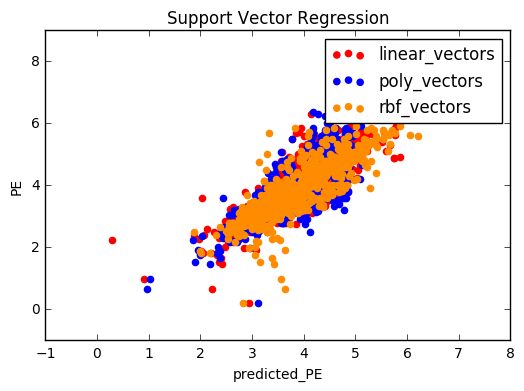

In [23]:
#Just playing around with plotting. Somehow show r^2? 
plt.scatter(predicted_poly_PE, y_cv, color='red', label='linear_vectors')
plt.scatter(predicted_linear_PE, y_cv, color='blue', label='poly_vectors')
plt.scatter(predicted_rbf_PE, y_cv, color='darkorange', label='rbf_vectors')
plt.hold('on')
plt.xlabel('predicted_PE')
plt.ylabel('PE')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [24]:
#Now we test the test well. Again, probably a better way to frame data, so this is sloppy.
y_test_PE = test_well['PE']

In [25]:
test_vectors_1 = test_well.drop(['PE', 'Formation', 'Well Name', 'Depth'], axis=1)

In [26]:
test_vectors_2 = scaler.transform(test_vectors_1)

In [27]:
Blind_PE_predict = clf_rbf.predict(test_vectors_2)

In [28]:
test_well['Blind_PE'] = Blind_PE_predict

In [29]:
test_well

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Blind_PE
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000,3.455556
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984,3.335734
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968,3.361371
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952,3.421818
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935,3.370234
...,...,...,...,...,...,...,...,...,...,...,...,...
1381,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060,4.451038
1382,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045,4.456850
1383,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030,4.438210
1384,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030,3.819175


In [30]:
#Adapted from Brendon Hall and Allesandro Amato del Monte (SEG tutorial)
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

def compare_PE_plot(logs):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
        
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9,12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    ax[4].plot(logs.Blind_PE, logs.Depth, '-', color='blue')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im1, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim([0,200])
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim([0.2,2])
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim([-10,40])
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim([0,50])
    ax[4].set_xlabel("PE/Blind_PE")
    ax[4].set_xlim([0,10])
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

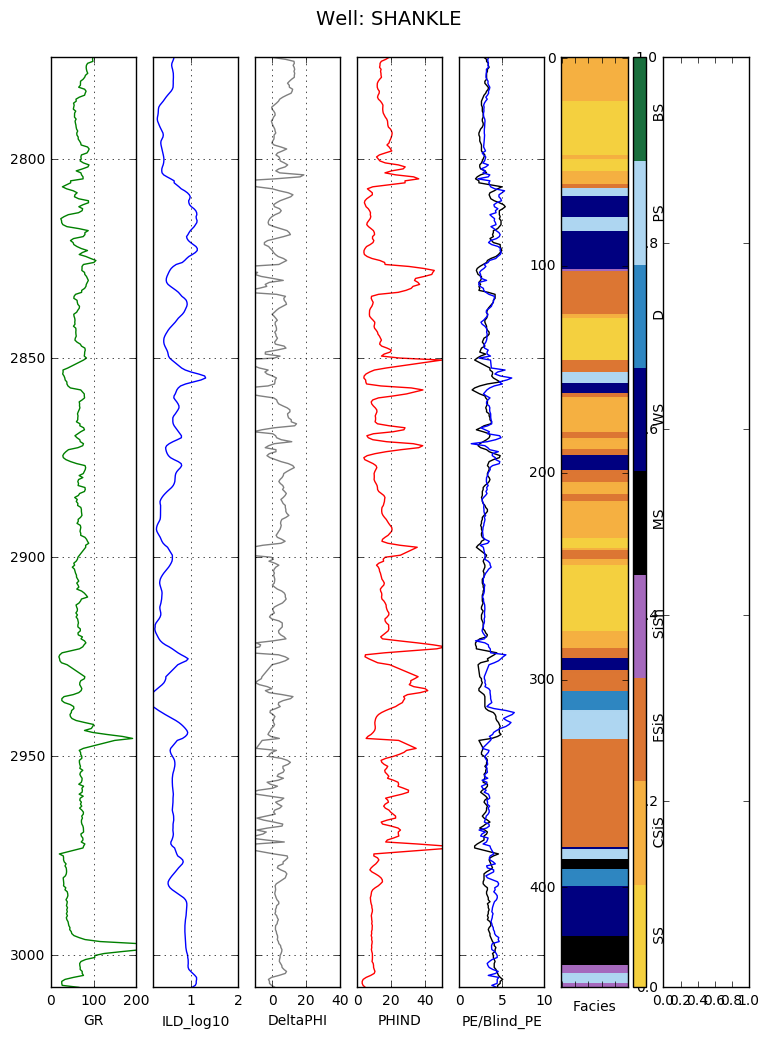

In [31]:
compare_PE_plot(test_well)

In [32]:
ALEX_D_No_PE

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,3,A1 SH,ALEXANDER D,2887.5,88.71,0.612,6.7,10.605,NaN,1,1.000
472,3,A1 SH,ALEXANDER D,2888.0,92.71,0.583,11.0,12.515,NaN,1,0.974
473,3,A1 SH,ALEXANDER D,2888.5,94.54,0.579,12.0,13.410,NaN,1,0.949
474,3,A1 SH,ALEXANDER D,2889.0,95.31,0.579,11.5,13.750,NaN,1,0.923
475,3,A1 SH,ALEXANDER D,2889.5,93.79,0.572,10.3,13.405,NaN,1,0.897
...,...,...,...,...,...,...,...,...,...,...,...
932,8,C LM,ALEXANDER D,3119.0,68.34,0.910,-1.8,8.065,NaN,2,0.043
933,8,C LM,ALEXANDER D,3119.5,67.87,0.926,1.8,8.175,NaN,2,0.034
934,8,C LM,ALEXANDER D,3120.0,66.00,0.928,6.3,8.540,NaN,2,0.026
935,8,C LM,ALEXANDER D,3120.5,67.39,0.898,9.6,9.755,NaN,2,0.017


In [33]:
#So now I need to put the PE back into the complete dataset...having problems
vectors_AD = ALEX_D_No_PE.drop(['Depth', 'PE', 'Well Name', 'Formation'], axis=1)

In [34]:
vectors_AD_2 = scaler.transform(vectors_AD)

In [35]:
PE = clf_rbf.predict(vectors_AD_2)

In [36]:
ALEX_D_No_PE['PE'] = PE

In [37]:
ALEX_D_No_PE

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,3,A1 SH,ALEXANDER D,2887.5,88.71,0.612,6.7,10.605,3.232059,1,1.000
472,3,A1 SH,ALEXANDER D,2888.0,92.71,0.583,11.0,12.515,3.686874,1,0.974
473,3,A1 SH,ALEXANDER D,2888.5,94.54,0.579,12.0,13.410,3.513839,1,0.949
474,3,A1 SH,ALEXANDER D,2889.0,95.31,0.579,11.5,13.750,3.329519,1,0.923
475,3,A1 SH,ALEXANDER D,2889.5,93.79,0.572,10.3,13.405,3.188560,1,0.897
...,...,...,...,...,...,...,...,...,...,...,...
932,8,C LM,ALEXANDER D,3119.0,68.34,0.910,-1.8,8.065,3.426749,2,0.043
933,8,C LM,ALEXANDER D,3119.5,67.87,0.926,1.8,8.175,3.224560,2,0.034
934,8,C LM,ALEXANDER D,3120.0,66.00,0.928,6.3,8.540,3.155561,2,0.026
935,8,C LM,ALEXANDER D,3120.5,67.39,0.898,9.6,9.755,3.554215,2,0.017


In [38]:
vectors_KIM = KIMZEY_No_PE.drop(['Depth', 'PE', 'Well Name', 'Formation'], axis=1)

In [39]:
vectors_KIM_2 = scaler.transform(vectors_KIM)

In [40]:
PE = clf_rbf.predict(vectors_KIM_2)

In [41]:
KIMZEY_No_PE['PE'] = PE

In [42]:
KIMZEY_No_PE

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1847,1,A1 SH,KIMZEY A,2918.5,73.816,0.769,5.226,11.3480,3.211498,1,1.000
1848,1,A1 SH,KIMZEY A,2919.0,75.118,0.627,8.198,13.1640,3.176697,1,0.978
1849,1,A1 SH,KIMZEY A,2919.5,72.434,0.535,10.867,15.0755,3.136395,1,0.956
1850,2,A1 SH,KIMZEY A,2920.0,66.161,0.568,4.566,16.9050,2.672616,1,0.933
1851,2,A1 SH,KIMZEY A,2920.5,63.104,0.650,2.083,15.8835,2.775486,1,0.911
...,...,...,...,...,...,...,...,...,...,...,...
2281,4,C LM,KIMZEY A,3136.0,86.023,0.688,10.949,11.7335,4.113992,2,0.405
2282,6,C LM,KIMZEY A,3136.5,101.037,0.732,10.179,12.0085,4.164020,2,0.393
2283,6,C LM,KIMZEY A,3137.0,153.374,0.748,8.198,13.4390,3.917026,2,0.381
2284,6,C LM,KIMZEY A,3137.5,144.117,0.672,9.188,13.4390,3.855115,2,0.369


In [43]:
#From here, I want to now include the generated PE into the original "facies_vectors.csv" but having problems.